<a href="https://colab.research.google.com/github/kasongo234/TP-DEEP-LEARNING/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys, platform, torch
print("Python:", sys.version)
print("Platform:", platform.platform())
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
PyTorch version: 2.8.0+cu126
CUDA available: True


device(type='cuda')

In [3]:
import sys, os, glob, textwrap
sys.path.append(os.path.abspath("project"))
print("\n".join(glob.glob("project/*")))

project/eval.py
project/models.py
project/collect_results.py
project/utils.py
project/train.py


In [10]:
import os, glob
path = "/content/drive/MyDrive/cnn-catsdogs_MeganeKasongo/data/train"
print("train existe :", os.path.isdir(path))
print("classes trouvées :", [d for d in os.listdir(path) if os.path.isdir(os.path.join(path,d))])
print("exemples de fichiers :", glob.glob(os.path.join(path, "*/*.jpg"))[:5])


train existe : True
classes trouvées : ['cat', 'dog']
exemples de fichiers : ['/content/drive/MyDrive/cnn-catsdogs_MeganeKasongo/data/train/cat/cat.8309.jpg', '/content/drive/MyDrive/cnn-catsdogs_MeganeKasongo/data/train/cat/cat.8316.jpg', '/content/drive/MyDrive/cnn-catsdogs_MeganeKasongo/data/train/cat/cat.8341.jpg', '/content/drive/MyDrive/cnn-catsdogs_MeganeKasongo/data/train/cat/cat.8345.jpg', '/content/drive/MyDrive/cnn-catsdogs_MeganeKasongo/data/train/cat/cat.8340.jpg']


In [34]:
import os, numpy as np, PIL.Image as Image
base = "/content/data"
for split in ["train","test"]:
    for cls in ["cat","dog"]:
        os.makedirs(f"{base}/{split}/{cls}", exist_ok=True)

def save_rand(path):
    arr = (np.random.rand(224,224,3)*255).astype(np.uint8)
    Image.fromarray(arr).save(path)

for i in range(20):
    save_rand(f"/content/data/train/cat/cat_{i:03d}.jpg")
    save_rand(f"/content/data/train/dog/dog_{i:03d}.jpg")
for i in range(5):
    save_rand(f"/content/data/test/cat/cat_{i:03d}.jpg")
    save_rand(f"/content/data/test/dog/dog_{i:03d}.jpg")

print("Mini dataset créé à /content/data ")


Mini dataset créé à /content/data 


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
!rm -rf data/train data/test
!wget -q https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -q cats_and_dogs_filtered.zip -d data
!mv data/cats_and_dogs_filtered/train data/train
!mv data/cats_and_dogs_filtered/validation data/test
!rm -rf data/cats_and_dogs_filtered cats_and_dogs_filtered.zip
!ls data/train


cats  dogs


Classes: ['cats', 'dogs'] | Taille train: 2000


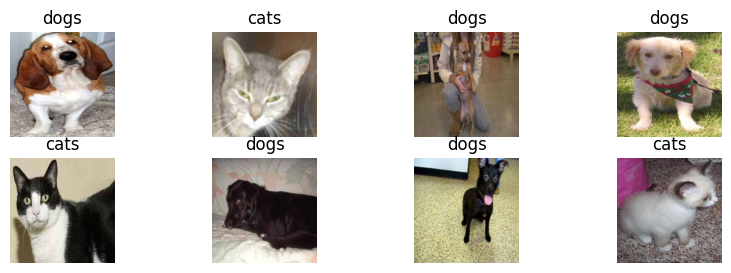

In [61]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
DATA_ROOT = "data"
if os.path.isdir(os.path.join(DATA_ROOT, "train")):
    tf = transforms.Compose([transforms.Resize((224,224)) , transforms.ToTensor()])
    ds = datasets.ImageFolder(root=os.path.join(DATA_ROOT, "train"), transform=tf)
    classes = ds.classes
    print("Classes:", classes, "| Taille train:", len(ds))
    loader = DataLoader(ds, batch_size=8, shuffle=True)
    imgs, labels = next(iter(loader))
    plt.figure(figsize=(10,3))
    for i in range(min(8, imgs.size(0))):
        plt.subplot(2,4,i+1)
        plt.imshow(imgs[i].permute(1,2,0))
        plt.title(classes[labels[i]])
        plt.axis("off")
    plt.show()
else:
    print("data/train introuvable – passe.")

CETTE PARTIE PERMET DE RECAPITULER TOUS LES RESULTATS DANS RUNS

/content/project
Device: cuda (GPU dispo: True)
Datasets -> train: 32 | val: 8 | test: 10
[1/20] train_loss=0.6632 acc=0.594 | val_loss=0.6791 acc=0.750 prec=0.750 rec=1.000 | 0.5s
[2/20] train_loss=0.7490 acc=0.375 | val_loss=0.6782 acc=0.750 prec=0.750 rec=1.000 | 0.2s
[3/20] train_loss=0.7556 acc=0.469 | val_loss=0.6865 acc=0.750 prec=0.750 rec=1.000 | 0.1s
[4/20] train_loss=0.6470 acc=0.594 | val_loss=0.6935 acc=0.375 prec=0.667 rec=0.333 | 0.1s
[5/20] train_loss=0.7356 acc=0.469 | val_loss=0.6971 acc=0.250 prec=0.000 rec=0.000 | 0.1s
[6/20] train_loss=0.7169 acc=0.531 | val_loss=0.7049 acc=0.250 prec=0.000 rec=0.000 | 0.1s
[7/20] train_loss=0.6640 acc=0.562 | val_loss=0.7159 acc=0.250 prec=0.000 rec=0.000 | 0.1s
[8/20] train_loss=0.7527 acc=0.469 | val_loss=0.7251 acc=0.250 prec=0.000 rec=0.000 | 0.1s
[9/20] train_loss=0.7597 acc=0.344 | val_loss=0.7317 acc=0.250 prec=0.000 rec=0.000 | 0.1s
[10/20] train_loss=0.6619 acc=0.562 | val_loss=0.7361 acc=0.250 prec=0.000 rec=0.000 | 0.1s

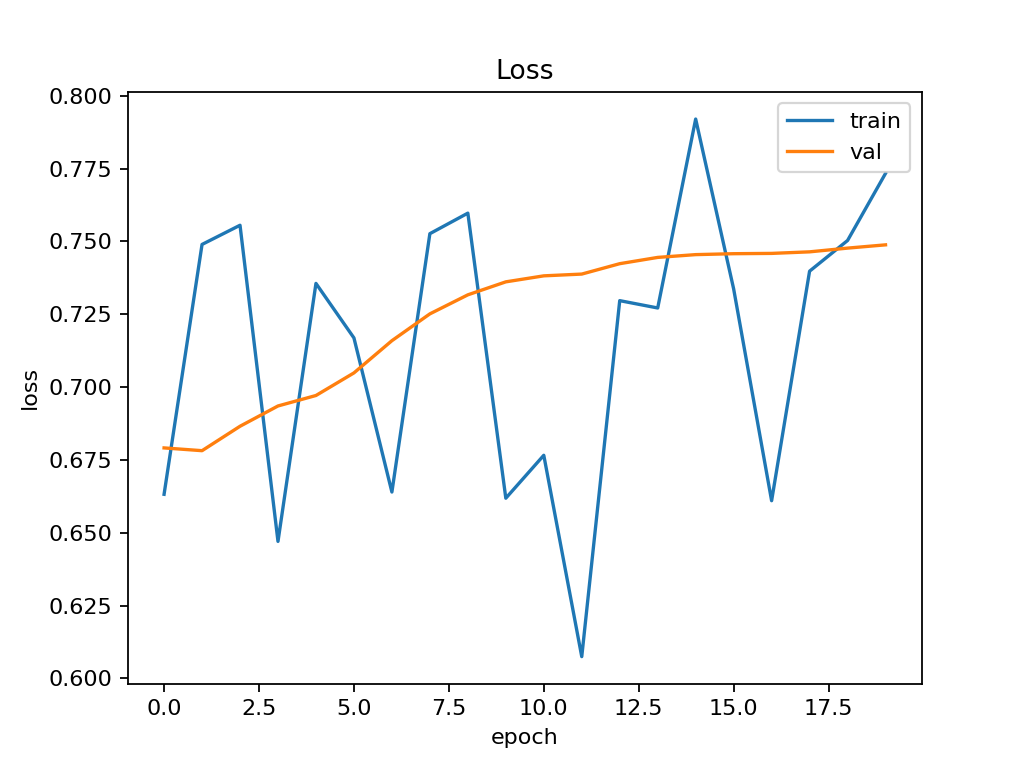

→ accuracy.png


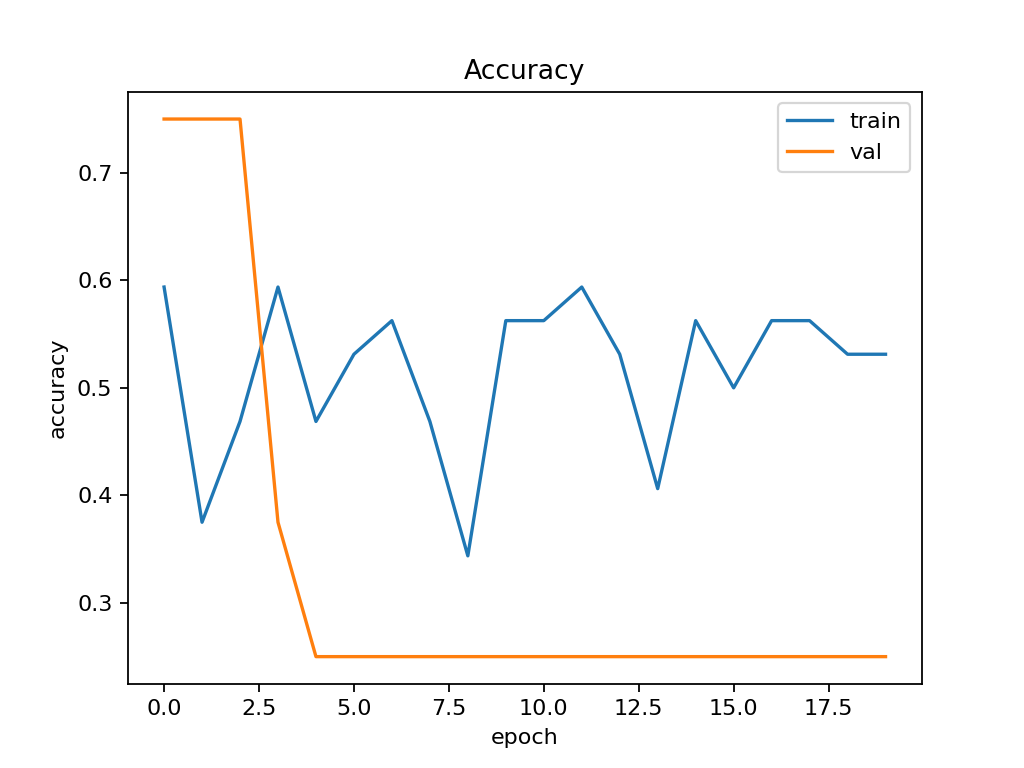

→ precision_recall.png


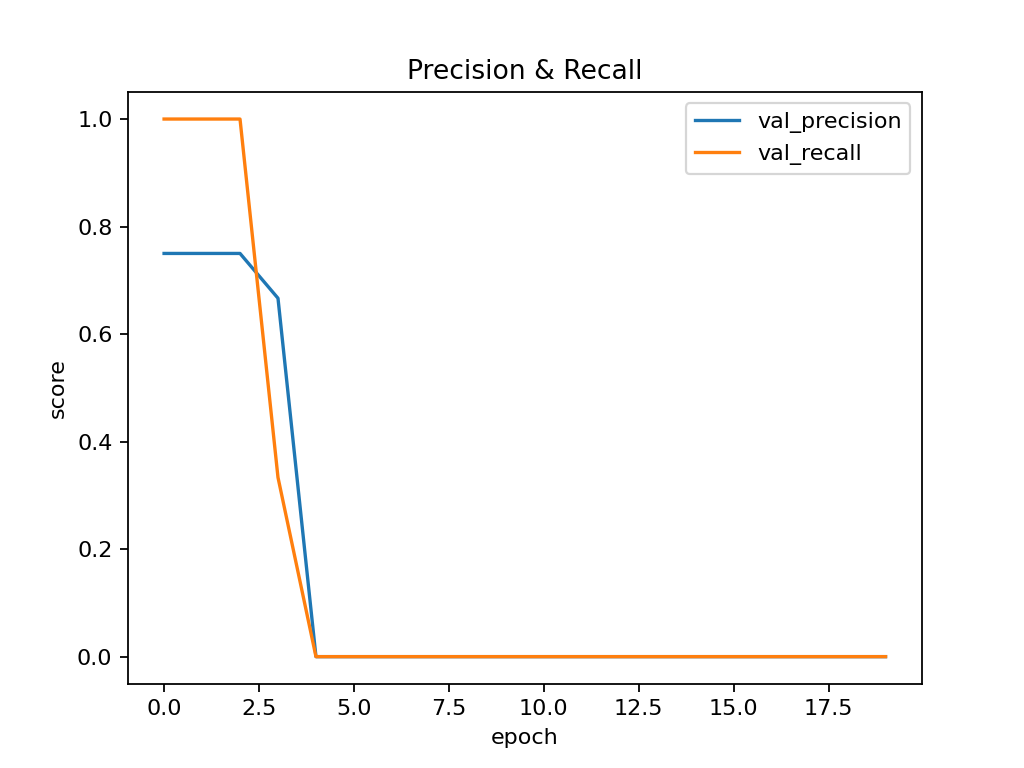

→ confusion_val.png


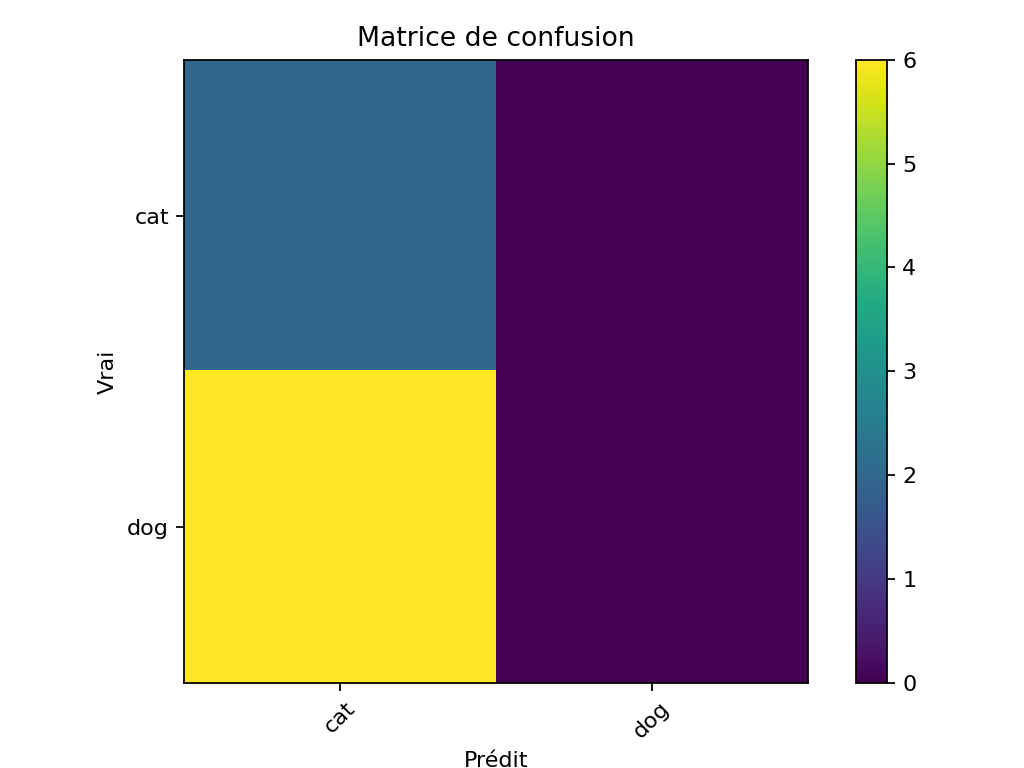

→ confusion_test.png


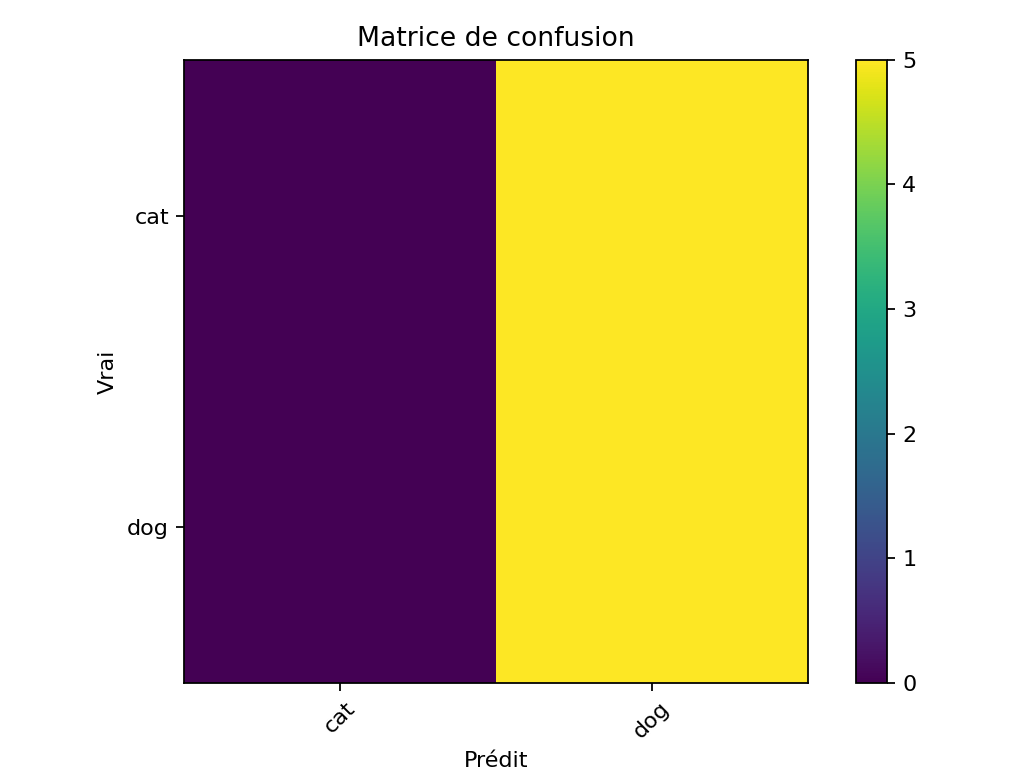


===  transfer_adam_lr0.001 ===
→ loss.png


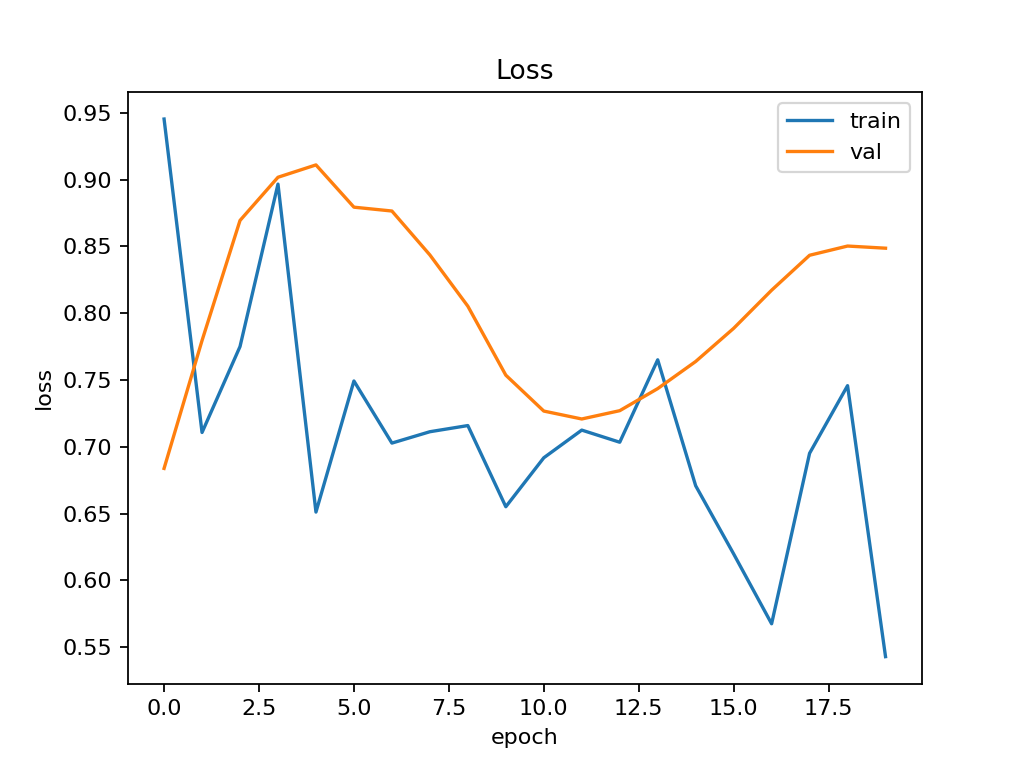

→ accuracy.png


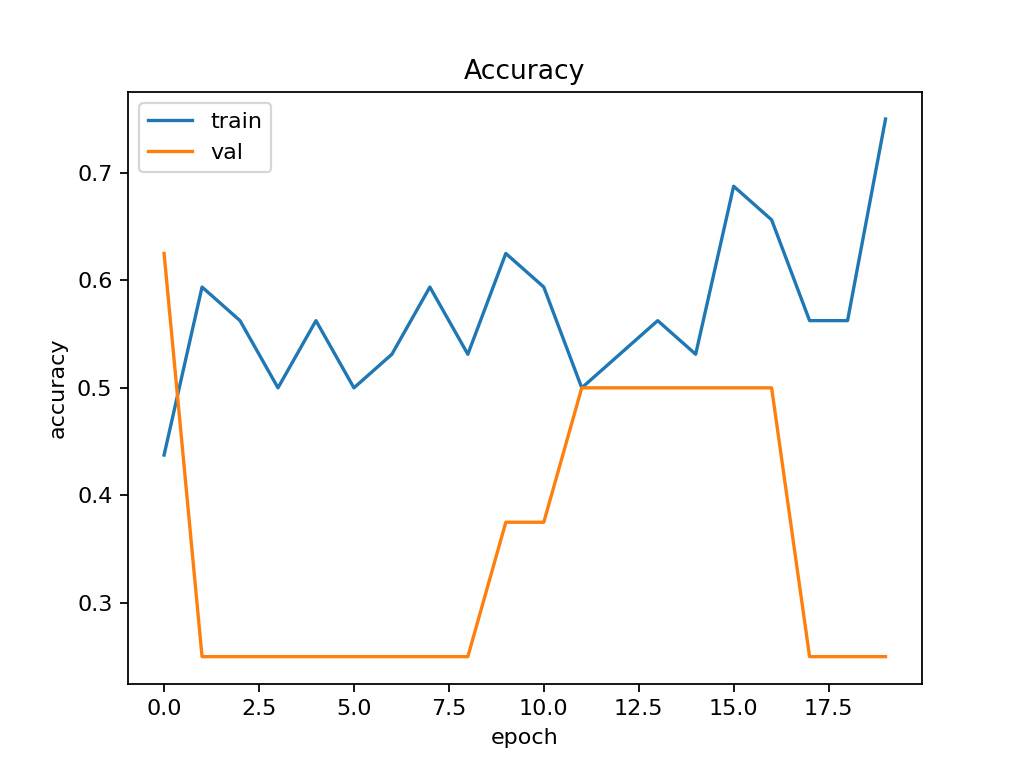

→ precision_recall.png


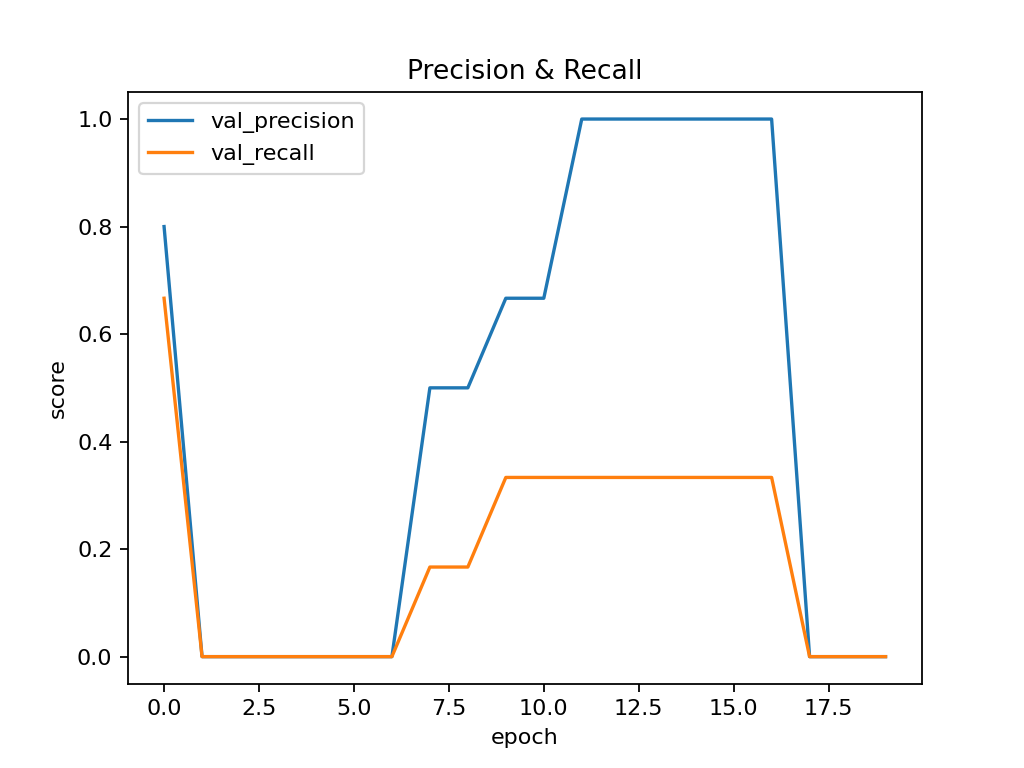

→ confusion_val.png


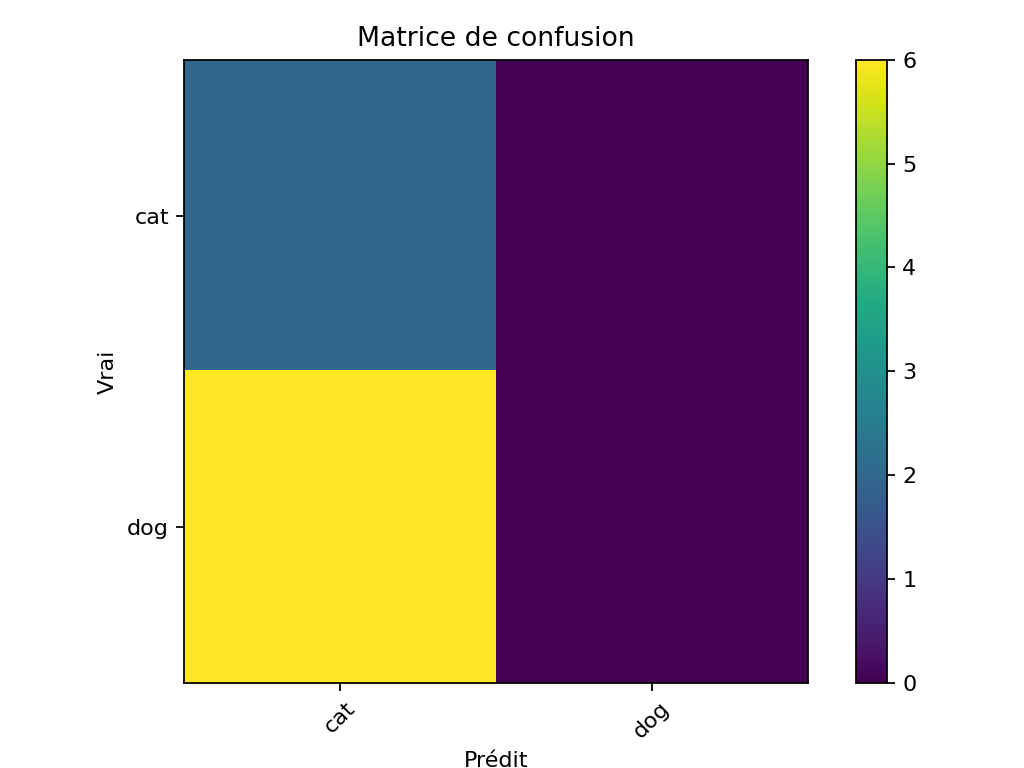

→ confusion_test.png


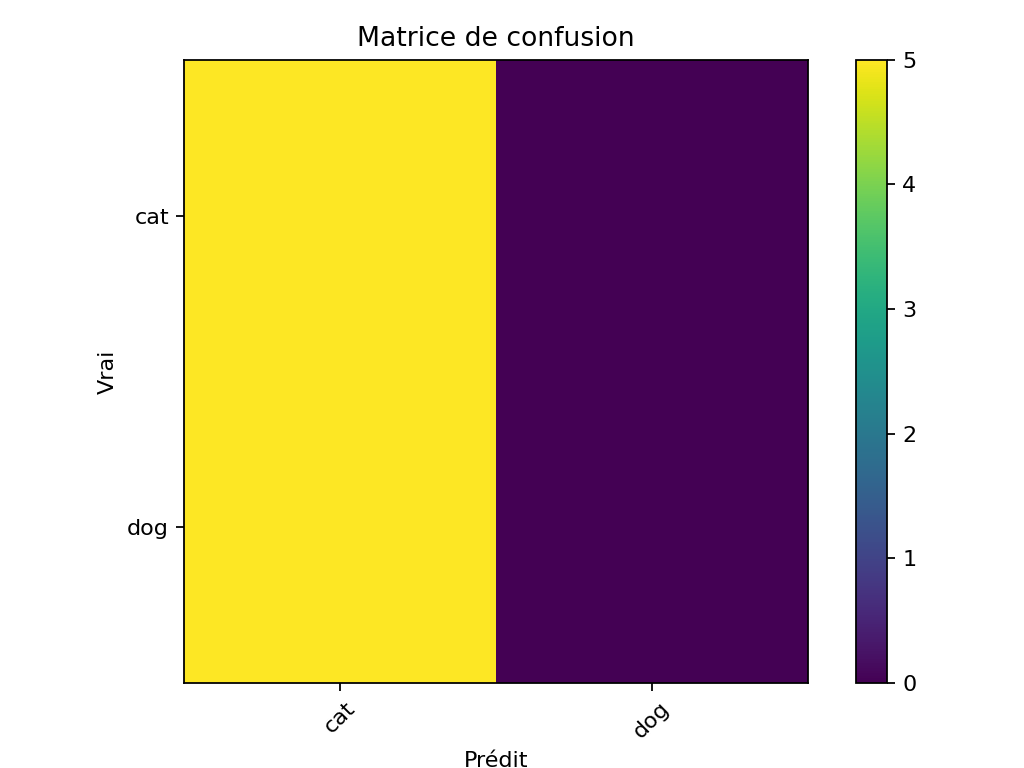

,run,epoch,train_loss,train_acc,val_loss,val_acc,val_precision,val_recall
0,fromscratch_adam_lr0.001,20,0.773367,0.53125,0.748836,0.25,0.0,0.0
1,transfer_adam_lr0.001,20,0.542957,0.75000,0.848621,0.25,0.0,0.0


In [39]:

#  1. Entraînement Expérience A (CNN from scratch)

%cd /content/project
!python train.py --exp A \
  --data_root /content/data \
  --epochs 20 \
  --batch_size 16 \
  --img_size 224 \
  --lr 1e-3 \
  --optimizer adam \
  --scheduler step \
  --augment \
  --subset 1.0


#  2. Entraînement Expérience B (Transfer Learning ResNet18)

!python train.py --exp B \
  --data_root /content/data \
  --epochs 20 \
  --batch_size 16 \
  --img_size 224 \
  --lr 1e-3 \
  --optimizer adam \
  --scheduler step \
  --augment \
  --pretrained \
  --subset 1.0


#  3. Visualisation : courbes + matrices de confusion
import os, glob, csv, pandas as pd
from IPython.display import display, Image, HTML

def find_run_dirs():
    for pat in ["/content/project/runs/*", "project/runs/*", "./runs/*"]:
        dirs = sorted(glob.glob(pat))
        if dirs:
            return dirs
    return []

run_dirs = find_run_dirs()
print(" Runs trouvés :", run_dirs[-4:] if run_dirs else "aucun")

if not run_dirs:
    display(HTML("<b>Aucun run trouvé. Lance d'abord un entraînement pour générer des sorties.</b>"))
else:
    for rd in run_dirs[-4:]:
        print(f"\n===  {os.path.basename(rd)} ===")
        for png in ["loss.png", "accuracy.png", "precision_recall.png", "confusion_val.png", "confusion_test.png"]:
            path = os.path.join(rd, png)
            if os.path.exists(path):
                print(f"→ {png}")
                display(Image(filename=path))
            else:
                print(f"(pas de {png})")


# 4. Tableau récapitulatif des résultats finaux

rows = []
for rd in run_dirs:
    hist = os.path.join(rd, "history.csv")
    if os.path.exists(hist):
        with open(hist, newline="") as f:
            data = list(csv.reader(f))
        if len(data) > 1:
            last = data[-1]
            rows.append({
                "run": os.path.basename(rd),
                "epoch": int(last[0]),
                "train_loss": float(last[1]),
                "train_acc": float(last[2]),
                "val_loss": float(last[3]),
                "val_acc": float(last[4]),
                "val_precision": float(last[5]),
                "val_recall": float(last[6]),
            })

if rows:
    df = pd.DataFrame(rows).sort_values(by=["run"])
    display(HTML("<h3> Résumé comparatif Exp A vs Exp B</h3>"))
    display(df)
else:
    print("\nAucun history.csv trouvé pour le récapitulatif.")
